In [1654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
import statsmodels.api as sm

In [1629]:
%run functions.py

In [1630]:
df_train_clean = pd.read_csv('../data/train_clean.csv')
df_test_clean = pd.read_csv('../data/test_clean.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Natural Log Model

In [1631]:
features = df_train_clean.columns.drop(['saleprice', 'yr_sold', 'year_built'])
features

Index(['ms_zoning', 'lot_area', 'condition_1', 'overall_qual', 'overall_cond',
       'year_remod/add', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond',
       'bsmt_unf_sf', 'total_bsmt_sf', 'central_air', '1st_flr_sf',
       'gr_liv_area', 'full_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'kitchen_qual', 'fireplaces', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'paved_drive', 'age', 'quality', 'remod',
       'bsmt_rating', 'bsmt_sf'],
      dtype='object')

In [1632]:
X = df_train_clean[features].copy()

In [1633]:
X = pd.get_dummies(X, columns=['central_air', 'condition_1'], drop_first=True)

In [1634]:
y = df_train_clean['saleprice'].copy()
y = y.map(np.log)

In [1635]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42)

Create a new linear regression model and fit it over the train data.  
Then, calculate the Train score, Test score, and Baseline score.

In [1636]:
model_log = LinearRegression()
model_log.fit(X_train, y_train)
calc_scores(model_log, X_train, y_train, X_test, y_test)

Train score  0.8619626847247706
Test score   0.8706200045036209
Baseline     0.8345827159479795


Predict the sale price for the test data.

In [1637]:
y_pred_log = model_log.predict(X_test)
resids_log = y_test - y_pred_log

Reverse the predictions for test and predicted sale price from natural log to price units.

In [1638]:
y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test)
y_train = np.exp(y_train)

Calculate metrics for true values vs. predicted values of the sales price.

In [1639]:
calc_metrics(y_test, y_pred)

RMSE 26867.456270082068
MSE  721860206.4247723
R2   0.8788337215910599
MAE  18318.110896748767


#### For 1 unit increase (square foot) in gr_liv_area, holding all other variables constant, we can expect the average price of a home to increase by 0.185%.
#### For 1 unit increase (year) in age, holding all other values constant, we can expect the average price of a home to drop by .224%.

In [1640]:
model_log.intercept_

19.795997648010594

In [1641]:
coef = zip(X_train.columns, model_log.coef_)
df_coef = pd.DataFrame(coef, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)
df_coef

,Feature,Coefficient
7,bsmt_qual,1.090921e-01
8,bsmt_cond,1.000285e-01
2,overall_qual,9.418610e-02
5,exter_qual,8.302564e-02
18,garage_cars,7.488483e-02
28,central_air_1,6.096128e-02
32,condition_1_5,5.774301e-02
3,overall_cond,5.672390e-02
6,exter_cond,5.023219e-02
34,condition_1_7,4.849378e-02


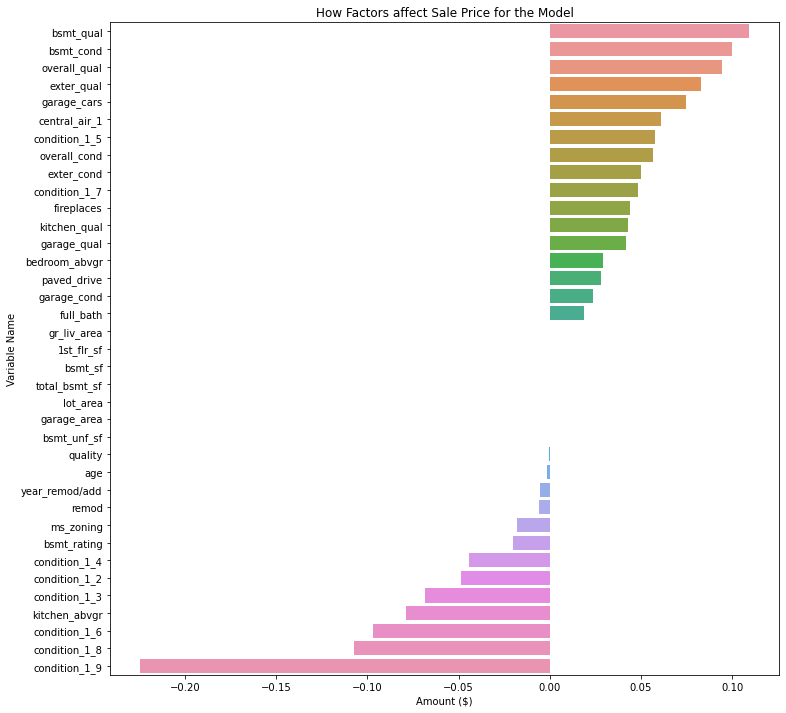

In [1642]:
plt.figure(figsize=(12,12))
plt.title('How Factors affect Sale Price for the Model')
ax = sns.barplot(x='Coefficient', y='Feature', data=df_coef)
ax.set(xlabel='Amount ($)', ylabel='Variable Name');
plt.savefig('../images/coef.jpg', transparent=True)

### Make predictions for unseen data (test_clean.csv - imputed NaN values with the mean).

In [1643]:
X_new = df_test_clean[features].copy()

In [1644]:
X_new = pd.get_dummies(X_new, columns=['central_air', 'condition_1'], drop_first=True)

Check to make sure all columns match for X_test and X_new, that all are numerical and there are no NaNs.

In [1645]:
X_new.shape, X_test.shape

((878, 37), (470, 37))

In [1646]:
X_test.columns.difference(X_new.columns)

Index([], dtype='object')

In [1647]:
X_new.isnull().sum()[X_new.isnull().sum() > 0].sort_index()

Series([], dtype: int64)

In [1648]:
X_new.dtypes[X_new.dtypes == 'object'].sort_index()

Series([], dtype: object)

Predict price on unknown data.

In [1649]:
y_pred_log = model_log.predict(X_new)
y_pred_new = np.exp(y_pred_log)

### Submit to Kaggle.

In [1650]:
y_pred_new = pd.DataFrame(y_pred_new)
y_pred_new = y_pred_new.astype(int)
y_pred_new.head()

,0
0,104329
1,152162
2,220140
3,118795
4,160558


In [1651]:
kaggle = pd.read_csv('../data/test.csv')
kaggle['sale_price_pred'] = y_pred_new.copy()
kaggle = kaggle[['Id', 'sale_price_pred']].copy()

In [1652]:
kaggle.to_csv('../kaggle/submission.csv', header = ['Id', 'SalePrice'], sep = ',', index = False)